In [46]:
import re
import random
import pandas as pd
import hashlib

In [47]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)



cards_to_age['head'] = cards_to_age['head'].str.strip()

# remove headers I don't want anymore
undesired_headers = ['CCH Axcess']
cards_to_age = cards_to_age.loc[~cards_to_age['head'].isin(undesired_headers), :].copy()

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.5) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [48]:
ave_order = ('age', 'mean')
sum_order = ('age', 'sum')

stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(ave_order)
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
"The Simulacra, Dick",181.401189,9.547431,28.601334,19
Windows PATH Variable,468.283668,15.609456,76.701312,30
Terraform,35.913366,17.956683,19.175225,2
Node.JS and React,978.623127,31.568488,105.147046,31
Azure Compute Gallery,302.517277,43.216754,80.681274,7
"Mexican Gothic, Moreno-Garcia",1227.650343,43.844655,192.015181,28
Django,1976.992894,49.424822,229.682491,40
Azure Functions Core Tools,910.869037,53.580532,146.386524,17
Node.js and Vite,2606.616944,63.576023,267.545137,41
Azure Files Documentation,3696.558492,63.733767,317.780425,58


# Histogram

sum of ages: ~47529.32


<Axes: >

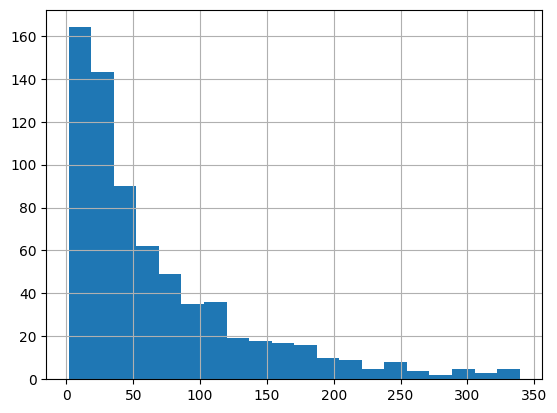

In [49]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~47529.32


<Axes: >

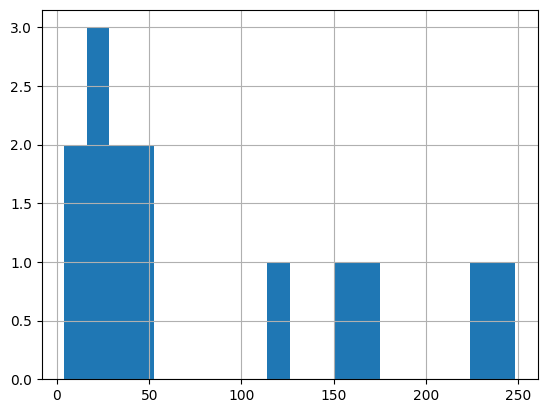

In [50]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Vocab']['age'].hist(bins=20)

# Completely Random Shuffle

In [51]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [52]:
existing_cards = existing_cards.sort_values('age', ascending=False)
remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
existing_cards.head(10)

Cards found: 700
Total card age: 47529.32


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count
0,Terraform Codebox,"In Terraform, the output block allows you to p...",554efafdb08b410f2cb22d46ae2abab7,339.115261,90.928731,339.115261,3637.149252,0.255340,40
1,Python + Oauth2.0,handler.wfile.write()\n\nWrites raw bytes to t...,b95e54b1c397ae6b6f3735f6a392b22a,333.093598,110.029467,333.093598,2530.677748,0.984288,23
2,pfSense,There is a wealth of additional information an...,aaa954788fcf28ad80a7ff360cd2b57e,332.828698,112.604869,332.828698,1126.048685,0.554115,10
3,Microsoft Purview,For data officers and CxO stakeholders:\n D...,aca88f19419a8400d3b218b2ef0f064b,331.892026,79.832486,331.892026,3991.624322,0.531571,50
4,JavaScript Concepts,Express.js: A minimalist web framework for Nod...,425c10164d26897fdad3f9d7c2c6f523,326.980698,87.110495,326.980698,3397.309323,0.792335,39
5,Python + Oauth2.0,Content-Type: application/x-www-form-urlencode...,38dede4a30833163a2984b269122170b,321.440894,110.029467,333.093598,2530.677748,0.984288,23
6,Azure Files Documentation,If your OU containing the storage account's co...,f704d232649e15b11bd7d43a57d0b9b8,317.780425,63.733767,317.780425,3696.558492,0.556155,58
7,Python,Q:\nWhat does the .stem attribute of a Path ob...,0bc10aa36364510a4e88a4b16346e5c2,311.459168,63.784957,311.459168,4911.441686,0.581182,77
8,Microsoft Purview,Extend SharePoint protection when files are do...,18220087edb513634873bc97c01fc1cb,304.152856,79.832486,331.892026,3991.624322,0.531571,50
9,Active Directory and Azure Files,Azure DNS Private Zone\nUsed to override DNS r...,2c6cce2ed73dd8c64267c999185a0319,302.672176,82.742416,302.672176,3061.469385,0.285282,37


# N-fold shuffle


## Age Sum

In [53]:
# n = 3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [54]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [55]:
# n = random.choice([2, 3, 3, 4, 5, 5])

# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [56]:
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()

# choices = ['floor', 'mod']
# option = random.choice(choices)
# if option == 'floor':
#     n=5
#     existing_cards['n_fold'] = existing_cards['count'] // n
#     print("floor dividing for n-fold")
# elif option == 'mod':
#     n=3
#     existing_cards['n_fold'] = existing_cards['count'] % n
#     print("modulo for n-fold")
# else: raise NotImplementedError


# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [57]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [58]:
existing_cards.head(10)['age'].sum()

np.float64(3221.415798947911)

In [59]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count
0,Terraform Codebox,"In Terraform, the output block allows you to p...",554efafdb08b410f2cb22d46ae2abab7,339.115261,90.928731,339.115261,3637.149252,0.255340,40
1,Python + Oauth2.0,handler.wfile.write()\n\nWrites raw bytes to t...,b95e54b1c397ae6b6f3735f6a392b22a,333.093598,110.029467,333.093598,2530.677748,0.984288,23
2,pfSense,There is a wealth of additional information an...,aaa954788fcf28ad80a7ff360cd2b57e,332.828698,112.604869,332.828698,1126.048685,0.554115,10
3,Microsoft Purview,For data officers and CxO stakeholders:\n D...,aca88f19419a8400d3b218b2ef0f064b,331.892026,79.832486,331.892026,3991.624322,0.531571,50
4,JavaScript Concepts,Express.js: A minimalist web framework for Nod...,425c10164d26897fdad3f9d7c2c6f523,326.980698,87.110495,326.980698,3397.309323,0.792335,39
5,Python + Oauth2.0,Content-Type: application/x-www-form-urlencode...,38dede4a30833163a2984b269122170b,321.440894,110.029467,333.093598,2530.677748,0.984288,23
6,Azure Files Documentation,If your OU containing the storage account's co...,f704d232649e15b11bd7d43a57d0b9b8,317.780425,63.733767,317.780425,3696.558492,0.556155,58
7,Python,Q:\nWhat does the .stem attribute of a Path ob...,0bc10aa36364510a4e88a4b16346e5c2,311.459168,63.784957,311.459168,4911.441686,0.581182,77
8,Microsoft Purview,Extend SharePoint protection when files are do...,18220087edb513634873bc97c01fc1cb,304.152856,79.832486,331.892026,3991.624322,0.531571,50
9,Active Directory and Azure Files,Azure DNS Private Zone\nUsed to override DNS r...,2c6cce2ed73dd8c64267c999185a0319,302.672176,82.742416,302.672176,3061.469385,0.285282,37


In [60]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 67.899'